In [1]:
import pickle

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import preprocessing
import matplotlib.image as mpimg

scaler = preprocessing.MinMaxScaler((0,1))

import glob
import re
import pickle

In [2]:
## 定义需要处理的函数
def img_to_array(imageFile):
    img = mpimg.imread(imageFile).astype(np.float)
    img=img[:,:,0]
    img=1-img
    return img.reshape((50,50,1))

def find_name(x):
    return re.search(r'(ref_.*)\+\d',x).group(1)

def find_pos(path):
    return re.search(r'ref_.*\+(\d+-\d+)\.p',path).group(1)

def get_real_pos(path):
    path=path['path']
#     print(type(path))
    try:
        starid=find_name(path)
        rel_pos=find_pos(path)
        l_pos_idx,r_pos_idx=rel_pos.split('-')
        
        #按格式整理后的路径修改
        path=starid_path_dict.get(starid)
        #次处按相对路径做了修改，初始代码和数据是放在一个文件夹了，现在多了一层/code/将.改成..
        path=path.replace(r'.',r'..')
        
        data=pd.read_table(path,sep=u' ',names=['time','data','dev'])
        data.sort_values(by='time',ascending=True,inplace=True)
        return data.time[eval(l_pos_idx)],data.time[eval(r_pos_idx)]
    except:
        return 'NN','NN'

def get_rel_pos(path):
    path=path['path']
#     print(type(path))
    try:
        starid=find_name(path)
        rel_pos=find_pos(path)
        l_pos_idx,r_pos_idx=rel_pos.split('-')
        return eval(l_pos_idx),eval(r_pos_idx)
    except:
        return 'NN','NN'

def get_breakpoints_apply(df):
    
    #按格式整理后的路径修改
    path=starid_path_dict.get(df['starid'])
    #次处按相对路径做了修改，初始代码和数据是放在一个文件夹了，现在多了一层/code/将.改成..
    path=path.replace(r'.',r'..')
    
    data=pd.read_table(path,sep=u' ',names=['time','data','dev'])
    data.sort_values(by='time',ascending=True,inplace=True)
    breakpoints=get_breakpoints(data)
    return breakpoints

def get_breakpoints(data):
    diff=data.time.diff()
    diff.fillna(method='bfill',inplace=True)
    breakpoints,=np.where(diff.values>diff.mean()*4)
    breakpoints=np.append(breakpoints,len(data))
    breakpoints=np.append(0,breakpoints)
    return breakpoints

def show_breakpoints(data,breakpoints):
    diff=data.time.diff()
    diff.fillna(method='bfill',inplace=True)
    fig, ax1 = plt.subplots(figsize=(5,5))
    ax2 = ax1.twinx()
    ax1.plot(range(len(data)),data.time,c='b')
    ax2.scatter(range(len(data)),diff,c='r')
    ax2.vlines(breakpoints,0,diff.max(),linestyles='dashed')
    ax1.set_xlabel("index")
    ax1.set_ylabel("time")
    ax2.set_ylabel("time_diff")
    plt.show()

def get_whole_data(insp_path):
    
    ##按格式整理后的路径修改
    #次处按相对路径做了修改，初始代码和数据是放在一个文件夹了，现在多了一层/code/将.改成..
    insp_path=insp_path.replace(r'.',r'..')
    
    data=pd.read_table(insp_path,sep=u' ',names=['time','data','dev'])
    data.sort_values(by='time',ascending=True,inplace=True)
    breakpoints=get_breakpoints(data)
    # show_breakpoints(data,breakpoints)
    whole_data=np.array([0])
    #     whole_dev=np.array([0])
    for i in range(len(breakpoints)-1):
        new_data=data.loc[breakpoints[i]:breakpoints[i+1]-1,'data'].values
        gap=np.median(whole_data)-np.median(new_data)
        new_data=new_data+gap
        whole_data=np.concatenate((whole_data,new_data))
    return whole_data

def autocorrelation(x,lags):#计算lags阶以内的自相关系数，返回lags个值，分别计算序列均值，标准差
    n = len(x)
    x = np.array(x)
    result = [np.correlate(x[i:]-x[i:].mean(),x[:n-i]-x[:n-i].mean())[0]/(x[i:].std()*x[:n-i].std()*(n-i)) for i in range(1,lags+1)]
    return result[-1]

def autocorrelation_diff(x,lags):#计算lags阶以内的自相关系数，返回lags个值，分别计算序列均值，标准差
    n = len(x)
    x = np.array(x)
    result = [np.correlate(x[i:]-x[i:].mean(),x[:n-i]-x[:n-i].mean())[0]/(x[i:].std()*x[:n-i].std()*(n-i)) for i in range(1,lags+1)]
    result = np.array(result)
    diff_=result[:-1]-result[1:]
    return diff_.mean()

def get_auto_corr(starid,lag=5):
    whole_data=get_whole_data(starid_path_dict.get(starid))
    auto_corr=autocorrelation(-whole_data,lag)
    return auto_corr

In [3]:
#生成starid 到对应数据文档路径的映射字典,这部分需按实际运行目录重新生成
# with open('./file_lst.pickle','rb') as f:
#     files_lst=pickle.load(f)

#files_lst=glob.glob(r'./AstroSet/*/ref*')
# starid_path_dict={}
# for file_path in files_lst:
#     starid_path_dict[file_path.split('/')[-1]]=file_path

# with open('./starid_path_dict.pickle','wb') as f:
#     pickle.dump(starid_path_dict,f)

In [4]:
#starid_path_dict 初赛的starid 到对应数据文档路径的映射字典
#starid_path_dict2 复赛的starid 到对应数据文档路径的映射字典
with open('../user_data/starid_path_dict2.pickle','rb') as f:
    starid_path_dict=pickle.load(f)

In [20]:
starid_path_dict.get('ref_021_24960425-G0014_628217_42591')

'./AstroSet\\021_24960425-G0014\\ref_021_24960425-G0014_628217_42591'

In [21]:
path_pred=r'../user_data/finded_result/*.png'

pool_pred=glob.glob(path_pred)

print('读取到候选天体事件{}个'.format(len(pool_pred)))

读取到候选天体事件21608个


In [14]:
#as files are still be generated record the current files
# with open('./pool_pred_20200729.pickle','wb') as f:
#     pickle.dump(pool_pred,f)

In [8]:
#读取训练的模型，模型迭代好几版了，各有优缺点，默认202009122版，注意tensorflow版本，亦可重新训练下
from tensorflow.keras.models import load_model
model = load_model("../user_data/trained_model/LeNet_202009122_img_50_50.h5")

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 46, 46, 6)         156       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 23, 23, 6)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 20, 20, 16)        1552      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 10, 10, 16)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 8, 8, 32)          4640      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 4, 4, 32)          0         
_________________________________________________________________
flatten (Flatten)            (None, 512)               0

In [9]:
pool_pred_starids=set([name for name in map(find_name,pool_pred)])

In [10]:
x_size=len(pool_pred)
x = np.zeros((x_size, 50,50,1))
#train sample only
for i in range(x_size):
    x[i] = img_to_array(pool_pred[i])

In [11]:
pred_y=model.predict(x)

y=np.apply_along_axis(np.argmax,1,pred_y)

score=np.apply_along_axis(np.max,1,pred_y)

In [12]:
predicts=pd.DataFrame({'starid':[name for name in map(find_name,pool_pred)],\
                       'event':y,\
                       'score':score,\
                       'path':pool_pred})

In [13]:
predicts.head()

,starid,event,score,path
0,ref_021_24960425-G0014_628217_42591,0,1.0,../user_data/finded_result\ref_021_24960425-G0...
1,ref_021_24960425-G0014_628618_19794,0,1.0,../user_data/finded_result\ref_021_24960425-G0...
2,ref_021_24960425-G0014_628619_19671,0,1.0,../user_data/finded_result\ref_021_24960425-G0...
3,ref_021_24960425-G0014_628668_18312,0,1.0,../user_data/finded_result\ref_021_24960425-G0...
4,ref_021_24960425-G0014_628684_16349,0,1.0,../user_data/finded_result\ref_021_24960425-G0...


In [14]:
len(predicts.loc[predicts.event!=0].sort_values(by='score',ascending=False))

49

In [41]:
# predicts.loc[predicts.event!=0].sort_values(by='score',ascending=False).to_csv('res_20200909.csv')

In [15]:
final_predicts=predicts.loc[predicts.event!=0].sort_values(by='score',ascending=False).copy()

In [16]:
final_predicts.head()

,starid,event,score,path
166,ref_021_24960425-G0014_641731_14386,1,1.000000,../user_data/finded_result\ref_021_24960425-G0...
8124,ref_043_12010765-G0013_496916_197051,2,1.000000,../user_data/finded_result\ref_043_12010765-G0...
15522,ref_044_12870595-G0013_448543_22840,1,1.000000,../user_data/finded_result\ref_044_12870595-G0...
570,ref_022_14110255-G0013_363312_33800,2,0.999999,../user_data/finded_result\ref_022_14110255-G0...
3194,ref_041_16810765-G0013_510950_21479,1,0.999999,../user_data/finded_result\ref_041_16810765-G0...


In [17]:
#开始计算除softmax外的其他筛选参数及提取片段相对和绝对位置
#get real time 获得真实天文时间
final_predicts['l_pos']='N'
final_predicts['r_pos']='N'
final_predicts[['l_pos','r_pos']]=final_predicts.apply(get_real_pos,axis=1,result_type='expand')

#get rel idx 获得数据片段相对位置
final_predicts['l_pos_rel']='N'
final_predicts['r_pos_rel']='N'
final_predicts[['l_pos_rel','r_pos_rel']]=final_predicts.apply(get_rel_pos,axis=1,result_type='expand')

#计算5阶自回归系数，以排除一部分周期性的脉冲星，看情况使用作为筛选条件，阶数可在前面函数定义时定义lag
final_predicts['auto_corr']=final_predicts['starid'].apply(get_auto_corr)

#计算事件是否由两段时间观察得到的结果
final_predicts['breakpoints']=final_predicts.apply(get_breakpoints_apply,axis=1,result_type='reduce')

def overlap_break_p(df):
    bps=df['breakpoints']
    l=df['l_pos_rel']
    r=df['r_pos_rel']
    m_pos=(l+r)/2
    gap=r-l
    for bp in bps:
        if bp>=m_pos-0.015*gap and bp<=m_pos+0.015*gap:
            return 'Y'
    return 'N'

final_predicts['is_overlap_bp']=final_predicts.apply(overlap_break_p,axis=1)

#重新命名
final_predicts['event']=final_predicts['event'].replace({2:'microlensing',1:'flare star'})

C:\Users\CJA_HOME\WPy64-3760\python-3.7.6.amd64\lib\site-packages\numpy\core\fromnumeric.py:3257: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


In [18]:
## 20200912提交的成绩是这条,使用LeNet_202009122_img_50_50.h5
final_predicts.loc[(final_predicts.auto_corr<0.8) & \
                   (final_predicts.score>0.5) & \
                   (final_predicts.is_overlap_bp=='N'),\
                   ['starid','l_pos', 'r_pos','event']]

,starid,l_pos,r_pos,event
166,ref_021_24960425-G0014_641731_14386,2.458606e+06,2.458606e+06,flare star
8124,ref_043_12010765-G0013_496916_197051,2.458519e+06,2.458526e+06,microlensing
570,ref_022_14110255-G0013_363312_33800,2.458565e+06,2.458566e+06,microlensing
3194,ref_041_16810765-G0013_510950_21479,2.458505e+06,2.458505e+06,flare star
7604,ref_043_12010765-G0013_474914_29466,2.458519e+06,2.458526e+06,flare star
21151,ref_044_34820255-G0013_1288349_20418,2.458499e+06,2.458499e+06,flare star
7664,ref_043_12010765-G0013_474975_91886,2.458519e+06,2.458526e+06,flare star
4563,ref_043_00940255-G0013_131769_27879,2.458486e+06,2.458486e+06,flare star
7632,ref_043_12010765-G0013_474944_91913,2.458519e+06,2.458526e+06,flare star
13338,ref_044_12010765-G0013_131065_100362,2.458483e+06,2.458488e+06,microlensing


In [19]:
## 20200912提交的成绩是这条,使用LeNet_202009122_img_50_50.h5
final_predicts.loc[(final_predicts.auto_corr<0.8) & \
                   (final_predicts.score>0.5) & \
                   (final_predicts.is_overlap_bp=='N'),\
                   ['starid','l_pos', 'r_pos','event']].to_csv('../prediction_result/res_20200912.csv',header=False,index=False)

In [63]:
## 20200909提交的成绩是这条,使用LeNet_20200909_img_50_50.h5
final_predicts.loc[(final_predicts.auto_corr<0.8) & (final_predicts.score>0.98),\
                   ['starid','l_pos', 'r_pos','event']].head(50).to_csv('../prediction_result/res_20200909.csv',header=False,index=False)

,starid,l_pos,r_pos,event
166,ref_021_24960425-G0014_641731_14386,2.458606e+06,2.458606e+06,flare star
15522,ref_044_12870595-G0013_448543_22840,2.458492e+06,2.458502e+06,flare star
8124,ref_043_12010765-G0013_496916_197051,2.458519e+06,2.458526e+06,microlensing
9612,ref_044_00940255-G0013_1273778_7291,2.458501e+06,2.458504e+06,microlensing
6063,ref_043_04700255-G0013_29528_21239,2.458512e+06,2.458519e+06,flare star
4475,ref_043_00940255-G0013_1265997_24761,2.458486e+06,2.458486e+06,microlensing
5902,ref_043_04700255-G0013_28874_19479,2.458509e+06,2.458512e+06,flare star
7604,ref_043_12010765-G0013_474914_29466,2.458519e+06,2.458526e+06,flare star
3194,ref_041_16810765-G0013_510950_21479,2.458505e+06,2.458505e+06,flare star
19032,ref_044_14110425-G0013_410983_22399,2.458496e+06,2.458499e+06,flare star


In [ ]:
#以下是其他一系列尝试，包括使用不同的识别LeNet版本和不同的阈值筛选，
#总体自回归系数小于0.8，模型softmax大于0.98的效果比较好，
#另外还可加入是否拼接的判断，在数量较多情况下进一步筛选

In [54]:
final_predicts.is_overlap_bp.value_counts()

N    36
Y    13
Name: is_overlap_bp, dtype: int64

In [55]:
final_predicts.loc[final_predicts.is_overlap_bp=='Y','starid'].to_list()

['ref_044_12870595-G0013_448543_22840',
 'ref_043_06300085-G0013_1457022_9648',
 'ref_043_06300085-G0013_1491366_16831',
 'ref_043_06300085-G0013_1457980_15779',
 'ref_022_13500085-G0014_288288_19986',
 'ref_043_04700255-G0013_29528_21239',
 'ref_043_06300085-G0013_1469618_32402',
 'ref_043_12010765-G0013_475112_87655',
 'ref_043_12010765-G0013_497481_81201',
 'ref_043_04700255-G0013_28874_19479',
 'ref_043_06300085-G0013_1469081_18682',
 'ref_043_12010765-G0013_475075_29192',
 'ref_043_12010765-G0013_474527_203568']

In [67]:
final_predicts.sort_values(by='score',ascending=False,inplace=True)

In [46]:
final_predicts.loc[(final_predicts.auto_corr>0.8) & (final_predicts.score>0.5),'starid'].to_list()

['ref_034_21640255-G0013_569111_13375',
 'ref_022_13500085-G0014_288288_19986',
 'ref_043_12010765-G0013_497481_81201',
 'ref_043_06300085-G0013_1469081_18682',
 'ref_044_02700085-G0013_1154500_44491']

In [50]:
final_predicts.loc[(final_predicts.auto_corr<0.8) & (final_predicts.score>0.5)].head()

,starid,event,score,path,l_pos,r_pos,l_pos_rel,r_pos_rel,auto_corr,breakpoints,is_overlap_bp
166,ref_021_24960425-G0014_641731_14386,flare star,1.000000,./Finded_0909\ref_021_24960425-G0014_641731_14...,2.45861e+06,2.45861e+06,804,1004,0.605088,"[0, 48, 338, 679, 1409, 1480, 1767, 1906, 2445]",N
8124,ref_043_12010765-G0013_496916_197051,microlensing,1.000000,./Finded_0909\ref_043_12010765-G0013_496916_19...,2.45852e+06,2.45853e+06,1147,1347,0.418682,"[0, 369, 460, 481, 811, 1015, 1232, 1363]",Y
15522,ref_044_12870595-G0013_448543_22840,flare star,1.000000,./Finded_0909\ref_044_12870595-G0013_448543_22...,2.45849e+06,2.4585e+06,2794,2994,0.757787,"[0, 1054, 1435, 1890, 2465, 2893, 3057, 3089, ...",Y
570,ref_022_14110255-G0013_363312_33800,microlensing,0.999999,./Finded_0909\ref_022_14110255-G0013_363312_33...,2.45857e+06,2.45857e+06,929,1129,0.570721,"[0, 317, 617, 1113, 1526]",N
3194,ref_041_16810765-G0013_510950_21479,flare star,0.999999,./Finded_0909\ref_041_16810765-G0013_510950_21...,2.45851e+06,2.45851e+06,26,226,0.459596,"[0, 620, 627, 1424]",N


In [56]:
final_predicts.loc[(final_predicts.auto_corr<0.8) & \
                   (final_predicts.score>0.5) & \
                   (final_predicts.is_overlap_bp=='N'),'starid'].to_list()

['ref_021_24960425-G0014_641731_14386',
 'ref_043_12010765-G0013_496916_197051',
 'ref_022_14110255-G0013_363312_33800',
 'ref_041_16810765-G0013_510950_21479',
 'ref_043_12010765-G0013_474914_29466',
 'ref_044_34820255-G0013_1288349_20418',
 'ref_043_12010765-G0013_474975_91886',
 'ref_043_00940255-G0013_131769_27879',
 'ref_043_12010765-G0013_474944_91913',
 'ref_044_12010765-G0013_131065_100362',
 'ref_044_18590595-G0013_382080_13703',
 'ref_044_12010765-G0013_500055_12380',
 'ref_044_04700255-G0013_49380_2518',
 'ref_043_12010765-G0013_474910_90832',
 'ref_044_00940255-G0013_1273778_7291',
 'ref_043_04700255-G0013_28382_6790',
 'ref_043_00940255-G0013_1178192_26131',
 'ref_044_34820255-G0013_1288250_20618',
 'ref_043_04700255-G0013_25654_19167',
 'ref_044_00940255-G0013_1273574_8915',
 'ref_043_04700255-G0013_28122_34945',
 'ref_044_34820255-G0013_808001_35420',
 'ref_043_16810765-G0013_762424_95233',
 'ref_044_34820255-G0013_1287904_7965',
 'ref_044_34820255-G0013_852269_24303',
 

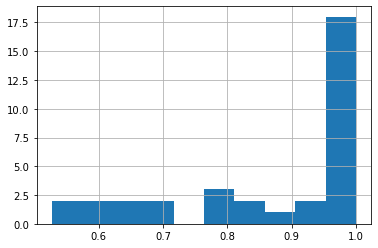

In [58]:
final_predicts.loc[(final_predicts.auto_corr<0.8) & \
                   (final_predicts.score>0.5) & \
                   (final_predicts.is_overlap_bp=='N'),\
                   ['starid','l_pos', 'r_pos','event','score']].score.hist()

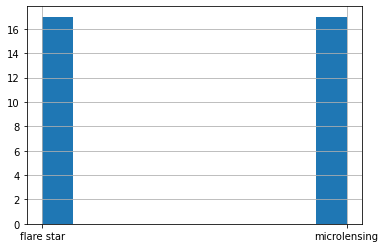

In [59]:
final_predicts.loc[(final_predicts.auto_corr<0.8) & \
                   (final_predicts.score>0.5) & \
                   (final_predicts.is_overlap_bp=='N'),\
                   ['starid','l_pos', 'r_pos','event','score']].event.hist()

In [60]:
len(final_predicts.loc[(final_predicts.auto_corr<0.8) & \
                   (final_predicts.score>0.5) & \
                   (final_predicts.is_overlap_bp=='N'),\
                   ['starid','l_pos', 'r_pos','event','score']])

34

In [44]:
final_predicts

,starid,event,score,path,l_pos,r_pos,l_pos_rel,r_pos_rel,auto_corr,breakpoints,is_overlap_bp
166,ref_021_24960425-G0014_641731_14386,flare star,1.000000,./Finded_0909\ref_021_24960425-G0014_641731_14...,2.45861e+06,2.45861e+06,804,1004,0.605088,"[0, 48, 338, 679, 1409, 1480, 1767, 1906, 2445]",N
8124,ref_043_12010765-G0013_496916_197051,microlensing,1.000000,./Finded_0909\ref_043_12010765-G0013_496916_19...,2.45852e+06,2.45853e+06,1147,1347,0.418682,"[0, 369, 460, 481, 811, 1015, 1232, 1363]",Y
15522,ref_044_12870595-G0013_448543_22840,flare star,1.000000,./Finded_0909\ref_044_12870595-G0013_448543_22...,2.45849e+06,2.4585e+06,2794,2994,0.757787,"[0, 1054, 1435, 1890, 2465, 2893, 3057, 3089, ...",Y
570,ref_022_14110255-G0013_363312_33800,microlensing,0.999999,./Finded_0909\ref_022_14110255-G0013_363312_33...,2.45857e+06,2.45857e+06,929,1129,0.570721,"[0, 317, 617, 1113, 1526]",N
3194,ref_041_16810765-G0013_510950_21479,flare star,0.999999,./Finded_0909\ref_041_16810765-G0013_510950_21...,2.45851e+06,2.45851e+06,26,226,0.459596,"[0, 620, 627, 1424]",N
1156,ref_034_21640255-G0013_569111_13375,microlensing,0.999958,./Finded_0909\ref_034_21640255-G0013_569111_13...,2.45852e+06,2.45852e+06,70,270,0.857123,"[0, 115, 429, 1079]",N
7604,ref_043_12010765-G0013_474914_29466,flare star,0.999944,./Finded_0909\ref_043_12010765-G0013_474914_29...,2.45852e+06,2.45853e+06,2686,2886,0.406504,"[0, 981, 1308, 1653, 2123, 2473, 2761, 2980]",Y
6212,ref_043_06300085-G0013_1457022_9648,flare star,0.999924,./Finded_0909\ref_043_06300085-G0013_1457022_9...,2.45852e+06,2.45852e+06,2570,2770,0.627099,"[0, 948, 958, 1271, 1921, 2669, 3087]",Y
21151,ref_044_34820255-G0013_1288349_20418,flare star,0.999861,./Finded_0909\ref_044_34820255-G0013_1288349_2...,2.4585e+06,2.4585e+06,506,706,0.601350,"[0, 486, 888, 1233]",N
6680,ref_043_06300085-G0013_1491366_16831,flare star,0.999759,./Finded_0909\ref_043_06300085-G0013_1491366_1...,2.45852e+06,2.45852e+06,2571,2771,0.685842,"[0, 948, 958, 1271, 1921, 2669, 3087]",Y


In [57]:
final_predicts.loc[(final_predicts.auto_corr<0.8) & \
                   (final_predicts.score>0.5) & \
                   (final_predicts.is_overlap_bp=='N'),\
                   ['starid','l_pos', 'r_pos','event']].to_csv('./res_20200912.csv',header=False,index=False)

In [41]:
final_predicts[['starid','l_pos', 'r_pos','event']].to_csv('./res_20200909.csv',header=False,index=False)

In [92]:
final_predicts.loc[(final_predicts.auto_corr<0.8) & (final_predicts.score>0.98),\
                   ['starid','l_pos', 'r_pos','event']].head(50).to_csv('./res_20200909.csv',header=False,index=False)

In [49]:
final_predicts.loc[(final_predicts.auto_corr<0.8) & (final_predicts.score>0.5),\
                   ['starid','l_pos', 'r_pos','event']].head(10)

,starid,l_pos,r_pos,event
166,ref_021_24960425-G0014_641731_14386,2.45861e+06,2.45861e+06,flare star
8124,ref_043_12010765-G0013_496916_197051,2.45852e+06,2.45853e+06,microlensing
15522,ref_044_12870595-G0013_448543_22840,2.45849e+06,2.4585e+06,flare star
570,ref_022_14110255-G0013_363312_33800,2.45857e+06,2.45857e+06,microlensing
3194,ref_041_16810765-G0013_510950_21479,2.45851e+06,2.45851e+06,flare star
7604,ref_043_12010765-G0013_474914_29466,2.45852e+06,2.45853e+06,flare star
6212,ref_043_06300085-G0013_1457022_9648,2.45852e+06,2.45852e+06,flare star
21151,ref_044_34820255-G0013_1288349_20418,2.4585e+06,2.4585e+06,flare star
6680,ref_043_06300085-G0013_1491366_16831,2.45852e+06,2.45852e+06,flare star
7664,ref_043_12010765-G0013_474975_91886,2.45852e+06,2.45853e+06,flare star


In [88]:
final_predicts.loc[(final_predicts.auto_corr<0.8) & (final_predicts.score>0.98),\
                   ['starid','l_pos', 'r_pos','event']].starid.to_list()

['ref_021_24960425-G0014_641731_14386',
 'ref_044_12870595-G0013_448543_22840',
 'ref_043_12010765-G0013_496916_197051',
 'ref_044_00940255-G0013_1273778_7291',
 'ref_043_04700255-G0013_29528_21239',
 'ref_043_00940255-G0013_1265997_24761',
 'ref_043_04700255-G0013_28874_19479',
 'ref_043_12010765-G0013_474914_29466',
 'ref_041_16810765-G0013_510950_21479',
 'ref_044_14110425-G0013_410983_22399',
 'ref_043_04700255-G0013_28382_6790',
 'ref_044_18590595-G0013_382080_13703',
 'ref_044_04700255-G0013_45239_27087',
 'ref_043_04700255-G0013_28122_34945',
 'ref_043_06300085-G0013_1457022_9648',
 'ref_044_14110425-G0013_326441_15380',
 'ref_044_12010765-G0013_500055_12380',
 'ref_044_34820255-G0013_1287904_7965',
 'ref_043_06300085-G0013_1491366_16831',
 'ref_044_04500085-G0013_1133981_14981',
 'ref_043_06300085-G0013_1469618_32402',
 'ref_044_12230255-G0013_1441255_28735',
 'ref_043_12010765-G0013_474910_90832',
 'ref_044_14110425-G0013_324602_9737',
 'ref_044_14110425-G0013_321481_15782',
 

In [126]:
final_predicts[['starid','l_pos', 'r_pos','event']]

,starid,l_pos,r_pos,event
1194,ref_022_15730595-G0013_481532_2590,2.45851e+06,2.45851e+06,microlensing
1776,ref_024_13500085-G0013_1397642_27534,2.4585e+06,2.4585e+06,microlensing
637,ref_021_24310595-G0013_746468_14893,2.45858e+06,2.45858e+06,flare star
7418,ref_031_12010765-G0013_517053_76902,2.45851e+06,2.45853e+06,microlensing
62,ref_021_18450425-G0014_352007_14642,2.45858e+06,2.45858e+06,flare star
6090,ref_031_12010765-G0013_251733_237296,2.45852e+06,2.45853e+06,microlensing
1156,ref_022_15730595-G0013_391462_6330,2.45854e+06,2.45854e+06,microlensing
9184,ref_031_12230255-G0013_396537_492471,2.45848e+06,2.45849e+06,microlensing
11005,ref_031_12230255-G0013_401749_506511,2.45848e+06,2.45849e+06,microlensing
4090,ref_031_06300085-G0013_20382_64595,2.45849e+06,2.4585e+06,flare star


In [ ]:
####End of coding

In [ ]:
### 以下处理同一个星体被检出两种事件的情况，实际上发生率很低，只是备用

In [26]:
predicts_event_lst=predicts.groupby('starid')['event'].apply(lambda x:x.to_list())
predicts_prob_lst=predicts.groupby('starid')['prob'].apply(lambda x:x.to_list())

In [27]:
final_pred=pd.concat([predicts_event_lst,predicts_prob_lst],axis=1)

In [28]:
final_pred['real_event']=final_pred[['event','prob']].apply(lambda x:x[0][np.argmax(x[1])],axis=1)

In [29]:
final_pred.tail(20)

,event,prob,real_event
starid,,,
ref_031_12230255-G0013_407699_368581,[2],[1.0],2
ref_031_12230255-G0013_407715_167208,[2],[0.999998927116394],2
ref_031_12230255-G0013_407721_506905,[2],[0.9999998807907104],2
ref_031_12230255-G0013_407736_371627,[2],[0.9987753033638],2
ref_031_12230255-G0013_407751_1178879,[1],[0.6667221188545227],1
ref_031_12230255-G0013_407815_357352,[1],[0.9991493225097656],1
ref_031_12230255-G0013_407818_1173546,[2],[0.827765941619873],2
ref_031_12230255-G0013_407841_358927,[2],[0.9876903295516968],2
ref_031_12230255-G0013_407849_360262,[2],[0.9997221827507019],2


In [59]:
final_pred['real_event']=final_pred['real_event'].replace({2:'microlensing'})

In [61]:
final_pred['real_event'].to_csv('./result20200730.csv',header=False,index=True)